In [36]:
import warnings, pandas as pd
warnings.filterwarnings("ignore")          
pd.options.mode.chained_assignment = None  


# Supply Chain Network Optimization

## Problem Statement
Transportation is expensive, unreliable (delays), and highly carbon-intensive.  
We aim to design a **hub–corridor network** and optimize flows with a multi-objective model.  
We will evaluate three policies:
- **Cost-first**
- **On-time-first**
- **Low-carbon-first**

Deliverables:
- Baseline KPIs
- Optimized plans
- Route maps for three policies
- A triangular trade-off diagram


## Data and KPIs

Key fields (if available):  
- `shipping_costs`, `delivery_time_deviation`, `fuel_consumption_rate`  
- `lead_time_days`, `loading_unloading_time`  
- GPS: `vehicle_gps_latitude`, `vehicle_gps_longitude`

### Baseline KPIs
- Total shipping cost
- Unit cost per shipment
- Lead time and loading/unloading time
- Mean deviation hours (expected delay)
- CO₂e total and intensity (proxy: `fuel × 3.16 kgCO₂e/L`)

This baseline snapshot is saved as **`kpi_snapshot.csv`** and serves as a benchmark.


In [37]:
# Load & normalize ====
import pandas as pd, numpy as np
from pathlib import Path

DATA_PATH = "dynamic_supply_chain_logistics_dataset.csv"

df = pd.read_csv(DATA_PATH, low_memory=False)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

ALIASES = {
    "timestamp": ["timestamp","time","datetime"],
    "lat": ["vehicle_gps_latitude","lat","latitude"],
    "lon": ["vehicle_gps_longitude","lon","longitude"],
    "fuel_rate": ["fuel_consumption_rate"],
    "eta_dev": ["delivery_time_deviation","eta_variation_hours"],
    "traffic": ["traffic_congestion_level"],
    "inv": ["warehouse_inventory_level"],
    "handling_time": ["loading_unloading_time"],
    "equip_ok": ["handling_equipment_availability"],
    "fulfill_ok": ["order_fulfillment_status"],
    "weather": ["weather_condition_severity"],
    "port_cong": ["port_congestion_level"],
    "cost": ["shipping_costs","shipping_cost","cost_usd"],
    "sup_rel": ["supplier_reliability_score"],
    "lead_days": ["lead_time_(days)","lead_time_days","lead_time"],
    "hist_demand": ["historical_demand"],
    "iot_temp": ["iot_temperature"],
    "cargo_ok": ["cargo_condition_status"],
    "route_risk": ["route_risk_level"],
    "customs_time": ["customs_clearance_time"],
    "drv_score": ["driver_behavior_score"],
    "fatigue": ["fatigue_monitoring_score"],
}

def pick(colset, cands):
    for c in cands:
        if c in colset: return c
    return None

COL = {}
for k, cands in ALIASES.items():
    COL[k] = pick(df.columns, cands)

if COL["timestamp"]:
    df[COL["timestamp"]] = pd.to_datetime(df[COL["timestamp"]], errors="coerce")

print("Columns detected:", COL)
print("Rows:", len(df))


Columns detected: {'timestamp': 'timestamp', 'lat': 'vehicle_gps_latitude', 'lon': 'vehicle_gps_longitude', 'fuel_rate': 'fuel_consumption_rate', 'eta_dev': 'delivery_time_deviation', 'traffic': 'traffic_congestion_level', 'inv': 'warehouse_inventory_level', 'handling_time': 'loading_unloading_time', 'equip_ok': 'handling_equipment_availability', 'fulfill_ok': 'order_fulfillment_status', 'weather': 'weather_condition_severity', 'port_cong': 'port_congestion_level', 'cost': 'shipping_costs', 'sup_rel': 'supplier_reliability_score', 'lead_days': 'lead_time_days', 'hist_demand': 'historical_demand', 'iot_temp': 'iot_temperature', 'cargo_ok': 'cargo_condition_status', 'route_risk': 'route_risk_level', 'customs_time': 'customs_clearance_time', 'drv_score': 'driver_behavior_score', 'fatigue': 'fatigue_monitoring_score'}
Rows: 32065


## KPIs (definitions)


Total Shipping Cost: $\sum \text{shipping\_costs}$.

Unit Cost: $\text{UnitCost}=\dfrac{\sum \text{shipping\_costs}}{N}$.

On-Time Rate: $\text{OnTime}=1-\overline{\text{DelayProbability}}$ (if available).

Late label from deviation (fallback): $\text{Late}=\mathbb{1}\{\ \text{delivery\_time\_deviation}>p75\ \}$.

Time Deviation (hours): mean of $\text{delivery\_time\_deviation}$.

CO₂e proxy (from fuel): $\text{CO2e}\approx \text{fuel (litres)}\times 3.16\ \text{kg CO₂e/litre}$.

These KPIs map to the optimization levers:

Objective terms: Cost $(c_{ij})$, Delay $(d_{ij})$ with weight $(\lambda_{\mathrm{sla}})$, CO₂e $(e_{ij})$ with weight $(\lambda_{\mathrm{co2}})$.

Hard caps (optional): SLA/late-risk cap $(D_{\max})$, emissions cap $(E_{\max})$, budget/capacity constraints.

In [38]:
# KPI COMPUTATION — robust to missing columns
import pandas as pd
import numpy as np

DATA_PATH = "dynamic_supply_chain_logistics_dataset.csv"  # update if needed
df = pd.read_csv(DATA_PATH, low_memory=False)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Column map (only used if present)
COL = dict(
    cost="shipping_costs",
    delay_prob="delay_probability",
    delay_dev="delivery_time_deviation",
    lead_time="lead_time_days",               # use your actual lead time column if different
    handling="loading_unloading_time",
    fuel="fuel_consumption_rate",             # proxy for CO2e (optional)
)

def has(col): return (col is not None) and (col in df.columns)
def smean(col): 
    return None if not has(col) else float(df[col].dropna().mean())
def stotal(col):
    return None if not has(col) else float(df[col].dropna().sum())

# ---- Cost KPIs ----
total_cost = stotal(COL["cost"])
unit_cost  = None if total_cost is None else total_cost / len(df)

# ---- Efficiency KPIs ----
lead_time_mean     = smean(COL["lead_time"])
handling_time_mean = smean(COL["handling"])

# ---- Reliability KPIs ----
avg_delay_prob = smean(COL["delay_prob"]) if has(COL["delay_prob"]) else None
on_time_rate   = None if avg_delay_prob is None else (1.0 - avg_delay_prob)

delay_dev_mean = smean(COL["delay_dev"])
# If no delay_probability, derive a late rate from deviation threshold (p75)
late_rate_from_dev = None
if (not has(COL["delay_prob"])) and has(COL["delay_dev"]):
    thr = float(df[COL["delay_dev"]].quantile(0.75))
    late_rate_from_dev = float((df[COL["delay_dev"]] > thr).mean())

# ---- Sustainability KPIs (proxy from fuel) ----
CO2_FACTOR = 3.16  # kg CO2e per litre of diesel
co2e_total     = None if not has(COL["fuel"]) else float(df[COL["fuel"]].dropna().sum() * CO2_FACTOR)
co2e_intensity = None if not has(COL["fuel"]) else float(df[COL["fuel"]].dropna().mean() * CO2_FACTOR)

kpi_rows = [
    ("Total_Shipping_Cost", total_cost, "$"),
    ("Unit_Cost", unit_cost, "$/record"),
    ("Lead_Time_Mean", lead_time_mean, "days"),
    ("Loading_Unloading_Time_Mean", handling_time_mean, "hours"),
    ("Delay_Probability_Avg", avg_delay_prob, "0–1"),
    ("On_Time_Rate", on_time_rate, "0–1"),
    ("Time_Deviation_Mean", delay_dev_mean, "hours"),
    ("Late_Rate_from_Deviation(p75)", late_rate_from_dev, "0–1"),
    ("CO2e_Total_Proxy", co2e_total, "kg CO2e"),
    ("CO2e_Intensity_Proxy", co2e_intensity, "kg CO2e / record"),
]

kpi_df = pd.DataFrame(kpi_rows, columns=["KPI","Value","Unit"])
def fmt(v):
    if v is None or (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
        return "-"
    # pick compact formatting automatically
    if abs(v) >= 1000: return f"{v:,.0f}"
    return f"{v:,.4f}"
kpi_df["Value_fmt"] = kpi_df["Value"].apply(fmt)
kpi_df_display = kpi_df[["KPI","Value_fmt","Unit"]]
display(kpi_df_display)

# Save for your report if you want
kpi_df.to_csv("kpi_snapshot.csv", index=False)
print("Saved KPIs → kpi_snapshot.csv")

,KPI,Value_fmt,Unit
0,Total_Shipping_Cost,"14,729,842",$
1,Unit_Cost,459.3745,$/record
2,Lead_Time_Mean,5.2275,days
3,Loading_Unloading_Time_Mean,2.2917,hours
4,Delay_Probability_Avg,0.6991,0–1
5,On_Time_Rate,0.3009,0–1
6,Time_Deviation_Mean,5.1776,hours
7,Late_Rate_from_Deviation(p75),-,0–1
8,CO2e_Total_Proxy,"811,792",kg CO2e
9,CO2e_Intensity_Proxy,25.3171,kg CO2e / record


Saved KPIs → kpi_snapshot.csv


In [40]:
# robust COL mapping
import pandas as pd
import numpy as np

if 'df' not in globals():
    DATA_PATH = "dynamic_supply_chain_logistics_dataset.csv"
    df = pd.read_csv(DATA_PATH, low_memory=False)
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

cols = set(df.columns)

def pick(*candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

COL = dict(
    # timestamps
    timestamp = pick("timestamp", "time", "date", "datetime"),
    # geo
    lat       = pick("vehicle_gps_latitude", "lat", "latitude"),
    lon       = pick("vehicle_gps_longitude", "lon", "longitude"),
    # costs
    cost      = pick("shipping_costs", "cost"),
    # ETA deviation (we use either one; both are fine)
    eta_dev   = pick("delivery_time_deviation", "eta_variation_hours"),
    # other optional KPIs used earlier
    handling  = pick("loading_unloading_time"),
    fuel      = pick("fuel_consumption_rate"),
)

print("COL mapping:", COL)
HAS_ETA = COL["eta_dev"] is not None


COL mapping: {'timestamp': 'timestamp', 'lat': 'vehicle_gps_latitude', 'lon': 'vehicle_gps_longitude', 'cost': 'shipping_costs', 'eta_dev': 'delivery_time_deviation', 'handling': 'loading_unloading_time', 'fuel': 'fuel_consumption_rate'}


In [41]:
# Build late_hours & late_label
assert COL["eta_dev"], "（delivery_time_deviation / eta_variation_hours）"

dev = pd.to_numeric(df[COL["eta_dev"]], errors="coerce")
df["late_hours"] = dev.clip(lower=0)  
tau = dev.quantile(0.75)              
df["late_label"] = (dev > tau).astype(float)

print("tau (hours) =", tau)
print("late rate (p>tau) =", float(df["late_label"].mean()))
print("mean late hours =", float(df["late_hours"].mean()))


tau (hours) = 9.249205980119978
late rate (p>tau) = 0.24999220333697178
mean late hours = 5.400179369915134


## Hub Generation

Cluster raw GPS points into hubs so that we can model flows on a network instead of millions of records.

1. Filter invalid GPS rows.  
2. Run KMeans (K=12) on GPS → hub centroids.  
3. Assign each record to nearest hub.  
4. Count points per hub as demand weight.  

**Outputs**  
- `hub_coords.csv` with columns: `hub, lat, lon, count` 

In [42]:
# Build hubs by KMeans
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

LAT, LON = COL["lat"], COL["lon"]


gps = df[[LAT, LON]].dropna()
gps = gps[gps[LAT].between(-90, 90) & gps[LON].between(-180, 180)]

K = 12 
km = KMeans(n_clusters=K, random_state=42, n_init=10).fit(gps[[LAT, LON]].to_numpy())
centers = km.cluster_centers_


nbrs = NearestNeighbors(n_neighbors=1).fit(centers)
dist, idx = nbrs.kneighbors(df[[LAT, LON]])
df["hub_id"] = idx[:, 0].astype(int)

hub_df = pd.DataFrame(centers, columns=["lat", "lon"]).reset_index().rename(columns={"index": "hub"})
cnt = df["hub_id"].value_counts().rename_axis("hub").reset_index(name="count")
hub_coords = hub_df.merge(cnt, on="hub", how="left").fillna({"count": 0}).sort_values("hub")
hub_coords.to_csv("hub_coords.csv", index=False)
print("Hubs saved → hub_coords.csv")
display(hub_coords.head())

TOTAL_SUPPLY = 10_000 
if hub_coords["count"].sum() > 0:
    weights = hub_coords["count"] / hub_coords["count"].sum()
else:
    weights = np.ones(len(hub_coords)) / len(hub_coords)

hub_demands = (weights * TOTAL_SUPPLY)
hub_demands = pd.Series(hub_demands.values, index=hub_coords["hub"].values, name="demand")
hub_demands.index.name = "hub"
hub_demands.to_csv("hub_demands.csv")  # 纯两列：hub, demand（索引是 hub）
print("Demands saved → hub_demands.csv")
print("Sample:", dict(list(hub_demands.items())[:5]))


Hubs saved → hub_coords.csv


,hub,lat,lon,count
0,0,32.811160,-107.526620,2321
1,1,32.699613,-79.483581,2624
2,2,32.801486,-117.006179,3328
3,3,45.586051,-82.080199,2049
4,4,45.355183,-104.951898,1890


Demands saved → hub_demands.csv
Sample: {0: 723.8421955403088, 1: 818.3377514423827, 2: 1037.8917823171682, 3: 639.0145017932325, 4: 589.4277249337283}


## Corridor Parameter Build

Turn hub-level statistics into arc-level parameters for optimization.

1. Connect each hub to its 3 nearest hubs.  
2. Broadcast hub stats to arcs (u→v).  
3. Merge geometric distances (`dist_km`).  
4. Convert fuel (litres/hour) → emissions factor (kg CO₂e/hour, ×3.16).  

**Outputs**  
- `arc_parameters.csv` → `hub_u, hub_v, dist_km, base_cost, exp_delay_hours, emissions_factor, capacity`  

In [43]:
# Build corridor parameters 
import numpy as np
import pandas as pd

np.random.seed(42)  # reproducibility

# Expect these objects to exist from previous cells:
# - g : DataFrame with columns ['hub','base_cost','exp_delay_hours','delay_prob','fuel_lph']
# - neighbor_map : dict[int -> set[int]]
# - arcs_df : DataFrame[['hub_u','hub_v','dist_km']]

required = {"hub","base_cost","exp_delay_hours","delay_prob","fuel_lph"}
assert required.issubset(set(g.columns)), f"Missing columns in g: {required - set(g.columns)}"

# 1) Broadcast hub stats to each outgoing neighbor corridor
rows = []
for _, r in g.iterrows():
    u   = int(r["hub"])
    base= float(r["base_cost"])
    dH  = float(r["exp_delay_hours"])
    pL  = float(r["delay_prob"])
    fph = float(r["fuel_lph"]) if pd.notna(r["fuel_lph"]) else np.nan

    for v in sorted(neighbor_map.get(u, set())):
        rows.append([u, int(v), base, dH, pL, fph])

param_df = pd.DataFrame(rows,
    columns=["hub_u","hub_v","base_cost","exp_delay_hours","delay_prob","fuel_lph"]
)

# 2) Merge geometric distances
param_df = param_df.merge(arcs_df, on=["hub_u","hub_v"], how="left")

# 3) Convert fuel (litres/hour) → emissions factor (kg CO2e/hour) as a placeholder
param_df["emissions_factor"] = (
    param_df["fuel_lph"].fillna(param_df["fuel_lph"].median()) * 3.16
)

# 4) Capacity (loose by default; scenario tuning later)
param_df["capacity"] = 1e6

# ========= Distance scaling (authoritative) =========
# 4.1 Per-origin average distance to stabilize scaling
avg_out_dist = (param_df.groupby("hub_u")["dist_km"].mean()
                .rename("avg_out_dist")).reset_index()
param_df = param_df.merge(avg_out_dist, on="hub_u", how="left")

# 4.2 Cost scales with distance: convert hub-level base_cost to per-km, then multiply by arc length
param_df["base_cost_per_km"] = param_df["base_cost"] / param_df["avg_out_dist"].clip(lower=1.0)
param_df["base_cost"] = param_df["base_cost_per_km"] * param_df["dist_km"]

# 4.3 Emissions scale with distance: assume average speed to convert hourly → per-km
AVG_SPEED_KMH = 60.0
param_df["emissions_per_km"] = (param_df["emissions_factor"] / AVG_SPEED_KMH)
param_df["emissions_factor"] = param_df["emissions_per_km"] * param_df["dist_km"]

# 4.4 Expected delay hours — gentle distance scaling to avoid extremes
scale = (param_df["dist_km"] / param_df["avg_out_dist"].clip(lower=1.0)).clip(lower=0.7, upper=1.3)
param_df["exp_delay_hours"] = param_df["exp_delay_hours"] * scale

# Cleanup helpers
param_df = param_df.drop(columns=["avg_out_dist","base_cost_per_km","emissions_per_km","fuel_lph"])

# 5) Final column order & export
param_df = param_df[
    ["hub_u","hub_v","dist_km","base_cost","exp_delay_hours","emissions_factor","capacity"]
].copy()

# Quick self-check: within each origin hub_u, min != max should hold (distance scaling worked)
chk = param_df.groupby("hub_u")[["base_cost","exp_delay_hours","emissions_factor"]].agg(['min','max']).head()
display(chk)

param_df.to_csv("arc_parameters.csv", index=False)
print("Saved → arc_parameters.csv", param_df.shape)
display(param_df.head())


base_cost             exp_delay_hours           emissions_factor  \
              min         max             min       max              min   
hub_u                                                                      
0      249.131161  528.126865        4.308714  8.001898       267.549220   
1      263.274487  617.077018        4.229671  7.855104       226.655229   
2      209.233231  587.213701        4.212580  7.823364       261.491281   
3      291.577207  547.565051        4.302790  7.971717       236.967613   
4      255.440454  497.597509        4.390669  8.154099       271.391341   

                   
              max  
hub_u              
0      567.170843  
1      531.246818  
2      733.876080  
3      445.011406  
4      528.669806

Saved → arc_parameters.csv (60, 7)


,hub_u,hub_v,dist_km,base_cost,exp_delay_hours,emissions_factor,capacity
0,0,2,885.664018,249.131161,4.308714,267.549220,1000000.0
1,0,4,1412.214599,397.246197,6.471763,426.614276,1000000.0
2,0,5,930.499159,261.742976,4.308714,281.093416,1000000.0
3,0,6,1609.925081,452.860788,7.377812,486.340407,1000000.0
4,0,10,1877.496814,528.126865,8.001898,567.170843,1000000.0


## Core Optimization Objective

We solve a multi-commodity min-cost flow with risk and carbon penalties:

$$
\min \sum_{i,j} \Big( c_{ij}\, x_{ij}
\;+\; \lambda_{\mathrm{sla}}\, d_{ij}\, x_{ij}
\;+\; \lambda_{\mathrm{co2}}\, e_{ij}\, x_{ij} \Big)
$$

**Where**
$x_{ij} \ge 0$: flow sent on arc 
𝑖
→
𝑗
i→j.

$c_{ij}$: base cost per unit flow on 
𝑖
→
𝑗
i→j.

$d_{ij}$: expected delay hours per unit flow.

$e_{ij}$: emissions factor per unit flow.

$\lambda_{\mathrm{sla}},\ \lambda_{\mathrm{co2}}$: business-set penalties (SLA breach price, carbon price).

**Subject to**

Supply at source(s): $\sum_{j} x_{s j} = \text{TOTAL\_SUPPLY}$.

Demand at destinations: $\sum_{u} x_{u k} - \sum_{v} x_{k v} = \text{demand}_{k}\;\; \forall k$.

Flow conservation at transshipment hubs: inflow = outflow.

Capacity: $x_{ij} \le \text{cap}_{ij}$.

(Optional caps) $\sum_{i,j} d_{ij}\,x_{ij} \le D_{\max}$, $\sum_{i,j} e_{ij}\,x_{ij} \le E_{\max}$.

In [26]:
# Optimization with Gurobi (3 policies) 
import pandas as pd
import numpy as np
from pathlib import Path

try:
    from gurobipy import Model, GRB, quicksum
except Exception as e:
    raise RuntimeError("Gurobi is required for this cell. Make sure gurobipy is installed and licensed.") from e

# -------- 1) Load arc parameters (from Cell5) --------
arc_path = Path("arc_parameters.csv")
arcs = pd.read_csv(arc_path)
req_cols = {"hub_u","hub_v","dist_km","base_cost","exp_delay_hours","emissions_factor","capacity"}
missing = req_cols - set(arcs.columns)
assert not missing, f"arc_parameters.csv missing columns: {missing}"

# Make sure indices are ints
arcs["hub_u"] = arcs["hub_u"].astype(int)
arcs["hub_v"] = arcs["hub_v"].astype(int)

# All hubs present in network
hubs = sorted(set(arcs["hub_u"]).union(set(arcs["hub_v"])))

# -------- 2) Build/Load demands --------
# Optional file with explicit per-destination demands: two columns [hub, demand]
dem_path = Path("hub_demands.csv")

if dem_path.exists():
    dem_df = pd.read_csv(dem_path)
    if set(dem_df.columns) >= {"hub","demand"}:
        demand = {int(r["hub"]): float(r["demand"]) for _, r in dem_df.iterrows()}
    else:
        raise ValueError("hub_demands.csv must have columns ['hub','demand']")
    # pick a source: the hub not listed as positive demand; or choose the smallest index
    # Here we assume only one source; adjust if you have multi-source
    dests = [k for k,v in demand.items() if v > 0]
    possible_sources = [h for h in hubs if h not in dests]
    source = min(possible_sources) if possible_sources else min(hubs)
    TOTAL_SUPPLY = float(sum(demand.values()))
else:
    # auto-construct: source=0, others are destinations, total supply=10000, proportional or equal
    source = 0
    dests = [h for h in hubs if h != source]
    TOTAL_SUPPLY = 10000.0

 
    mode = "equal"   # or "proportional"
    if mode == "proportional" and Path("hub_coords.csv").exists():
        cdf = pd.read_csv("hub_coords.csv")
        if "hub" in cdf.columns and "count" in cdf.columns:
            weight = cdf.set_index("hub")["count"].reindex(dests).fillna(1.0)
            weight = (weight / weight.sum()).to_dict()
            demand = {k: float(TOTAL_SUPPLY * weight[k]) for k in dests}
        else:
            # fallback to equal
            per = TOTAL_SUPPLY / len(dests)
            demand = {k: per for k in dests}
    else:
        per = TOTAL_SUPPLY / len(dests)
        demand = {k: per for k in dests}

print(f"Source hub  : {source}")
print(f"#Destinations: {len(dests)} -> {dests[:8]}{' ...' if len(dests) > 8 else ''}")
print(f"Total supply: {TOTAL_SUPPLY:,.0f}")

# Reachability quick check
reachable = set(arcs.loc[arcs["hub_u"]==source, "hub_v"].unique())
missing_dests = [d for d in dests if d not in reachable and d != source]
if missing_dests:
    print("Warning: some destinations not directly reachable from source (multihop will handle if paths exist):", missing_dests)

# -------- 3) Helpers to run a policy once --------
def solve_policy(lmb_sla: float, lmb_co2: float,
                 late_cap: float|None = None,
                 co2_cap: float|None = None,
                 name: str = "policy"):
    """
    Minimize sum_ij ( base_cost + λ_sla * exp_delay_hours + λ_co2 * emissions_factor ) * x_ij
    s.t. supply/demand, capacity, flow conservation
    Optional caps:
      - late_cap: sum(exp_delay_hours * x_ij) <= late_cap
      - co2_cap : sum(emissions_factor * x_ij) <= co2_cap
    """
    m = Model(name)
    m.Params.OutputFlag = 0  # quiet

    # Decision variables: x[u,v] >= 0
    idx = [(int(r.hub_u), int(r.hub_v)) for _, r in arcs.iterrows()]
    x = m.addVars(idx, name="x", lb=0.0)

    # Objective
    obj = quicksum(
        (float(r.base_cost) +
         lmb_sla * float(r.exp_delay_hours) +
         lmb_co2 * float(r.emissions_factor)) * x[int(r.hub_u), int(r.hub_v)]
        for _, r in arcs.iterrows()
    )
    m.setObjective(obj, GRB.MINIMIZE)

    # Capacity
    for _, r in arcs.iterrows():
        m.addConstr(x[int(r.hub_u), int(r.hub_v)] <= float(r.capacity))

    # Flow conservation
    # source: total outflow = TOTAL_SUPPLY
    m.addConstr(quicksum(x[source, v] for v in hubs if (source, v) in x) == TOTAL_SUPPLY)

    # destinations: inflow - outflow = demand_k
    for k, dem in demand.items():
        if k == source: 
            continue
        inflow  = quicksum(x[u, k] for u in hubs if (u, k) in x)
        outflow = quicksum(x[k, v] for v in hubs if (k, v) in x)
        m.addConstr(inflow - outflow == dem)

    # transshipment hubs (neither source nor destination): inflow == outflow
    trans = [h for h in hubs if (h != source and h not in demand)]
    for h in trans:
        inflow  = quicksum(x[u, h] for u in hubs if (u, h) in x)
        outflow = quicksum(x[h, v] for v in hubs if (h, v) in x)
        m.addConstr(inflow == outflow)

    # Optional caps (close by default)
    if late_cap is not None:
        m.addConstr(quicksum(float(r.exp_delay_hours) * x[int(r.hub_u), int(r.hub_v)]
                             for _, r in arcs.iterrows()) <= late_cap, name="late_cap")
    if co2_cap is not None:
        m.addConstr(quicksum(float(r.emissions_factor) * x[int(r.hub_u), int(r.hub_v)]
                             for _, r in arcs.iterrows()) <= co2_cap, name="co2_cap")

    m.optimize()

    # Extract plan
    plan_rows = []
    if m.Status == GRB.OPTIMAL:
        for (u, v) in x.keys():
            val = x[u, v].X
            if val > 1e-6:
                r = arcs[(arcs.hub_u==u) & (arcs.hub_v==v)].iloc[0]
                plan_rows.append(dict(
                    hub_u=u, hub_v=v,
                    dist_km=float(r.dist_km),
                    base_cost=float(r.base_cost),
                    exp_delay_hours=float(r.exp_delay_hours),
                    emissions_factor=float(r.emissions_factor),
                    capacity=float(r.capacity),
                    flow=float(val),
                    unit_cost=float(r.base_cost + lmb_sla*r.exp_delay_hours + lmb_co2*r.emissions_factor)
                ))
        plan = pd.DataFrame(plan_rows).sort_values(["hub_u","hub_v"]).reset_index(drop=True)

        # KPIs of the optimized plan
        total_cost   = float((plan["base_cost"] * plan["flow"]).sum())
        total_late_h = float((plan["exp_delay_hours"] * plan["flow"]).sum())
        total_co2    = float((plan["emissions_factor"] * plan["flow"]).sum())
        kpi = pd.DataFrame([
            ("Total_Shipping_Cost", total_cost),
            ("Expected_Deviation_Hours", total_late_h),
            ("Total_CO2e_Proxy", total_co2),
        ], columns=["KPI","Value"])

        return plan, kpi, m.ObjVal, m.Status
    else:
        return pd.DataFrame(), pd.DataFrame(), None, m.Status

# -------- 4) Run 3 policies --------
policies = [
    dict(name="cost-first",     l_sla=   0.0, l_co2=   0.0),   
    dict(name="on-time-first",  l_sla=  50.0, l_co2=   0.0),  
    dict(name="low-carbon-first", l_sla=  0.0, l_co2=  10.0),  
]

summary_rows = []
for p in policies:
    plan, kpi, obj, status = solve_policy(lmb_sla=p["l_sla"], lmb_co2=p["l_co2"], name=p["name"])
    if status == 2 and not plan.empty:  # 2 == OPTIMAL
        plan_file = f"optimized_plan_{p['name']}.csv"
        kpi_file  = f"optimized_kpis_{p['name']}.csv"
        plan.to_csv(plan_file, index=False)
        kpi.to_csv(kpi_file, index=False)
        print(f"{p['name']} → saved {plan_file}, {kpi_file}")

        summary_rows.append(dict(
            Strategy=p["name"],
            Total_Cost=float(kpi.loc[kpi["KPI"]=="Total_Shipping_Cost","Value"].values[0]),
            Deviation_Hours=float(kpi.loc[kpi["KPI"]=="Expected_Deviation_Hours","Value"].values[0]),
            CO2e_Proxy=float(kpi.loc[kpi["KPI"]=="Total_CO2e_Proxy","Value"].values[0]),
            Objective_Generalized=float(obj),
            Plan_File=plan_file
        ))
    else:
        print(f"{p['name']} infeasible or empty; status={status}")

summary = pd.DataFrame(summary_rows)
summary = summary.sort_values("Objective_Generalized").reset_index(drop=True)
summary.to_csv("strategy_comparison.csv", index=False)
print("\n Saved strategy comparison → strategy_comparison.csv")
display(summary)


Source hub  : 0
#Destinations: 12 -> [0, 1, 2, 3, 4, 5, 6, 7] ...
Total supply: 10,000
cost-first → saved optimized_plan_cost-first.csv, optimized_kpis_cost-first.csv
on-time-first → saved optimized_plan_on-time-first.csv, optimized_kpis_on-time-first.csv
low-carbon-first → saved optimized_plan_low-carbon-first.csv, optimized_kpis_low-carbon-first.csv

 Saved strategy comparison → strategy_comparison.csv


,Strategy,Total_Cost,Deviation_Hours,CO2e_Proxy,Objective_Generalized,Plan_File
0,cost-first,6.751660e+06,109354.227795,6.933047e+06,6.751660e+06,optimized_plan_cost-first.csv
1,on-time-first,6.763006e+06,108461.456089,6.921415e+06,1.218608e+07,optimized_plan_on-time-first.csv
2,low-carbon-first,6.808575e+06,109083.724078,6.916506e+06,7.597363e+07,optimized_plan_low-carbon-first.csv


In [33]:
#  Draw maps for three policies (cost/on-time/low-carbon) ====
import os
import pandas as pd
import numpy as np
import folium
from branca.colormap import LinearColormap

# ---------- config ----------
COORDS_FILE = "hub_coords.csv"
PLANS = [
    dict(csv="optimized_plan_cost-first.csv",     color_col="unit_cost",         out="map_cost.html",      title="Cost-first (color=unit_cost)"),
    dict(csv="optimized_plan_on-time-first.csv",  color_col="exp_delay_hours",   out="map_on_time.html",   title="On-time-first (color=exp_delay_hours)"),
    dict(csv="optimized_plan_low-carbon-first.csv", color_col="emissions_factor", out="map_low_carbon.html", title="Low-carbon-first (color=emissions_factor)"),
]

# ---------- helpers ----------
def load_nodes(coords_file):
    if not os.path.exists(coords_file):
        raise FileNotFoundError(f"Missing {coords_file}. Please run the hub clustering cell to generate it.")
    coords = pd.read_csv(coords_file)
    need = {"hub","lat","lon"}
    if not need.issubset(set(coords.columns)):
        raise ValueError(f"{coords_file} must have columns {need}")
    nodes = coords.set_index("hub")[["lat","lon"]].to_dict("index")
    center = (coords["lat"].mean(), coords["lon"].mean())
    return nodes, center, coords

def nice_cmap(vmin, vmax):
    # blue → light → yellow → orange → red
    return LinearColormap(["#2c7bb6","#abd9e9","#ffffbf","#fdae61","#d7191c"], vmin=vmin, vmax=vmax)

def draw_map_single(plan_csv, color_col, out_html, map_title=None):
    if not os.path.exists(plan_csv):
        print(f"skip: {plan_csv} not found. Run optimization first.")
        return

    plan = pd.read_csv(plan_csv)
    if "hub_u" not in plan.columns or "hub_v" not in plan.columns or "flow" not in plan.columns:
        print(f"skip: {plan_csv} missing required columns ['hub_u','hub_v','flow']")
        return
    if color_col not in plan.columns:
        print(f"skip: {plan_csv} missing color column '{color_col}'")
        return

    nodes, center, coords = load_nodes(COORDS_FILE)

    m = folium.Map(location=center, zoom_start=4, tiles="cartodbpositron")
    vmin, vmax = float(plan[color_col].min()), float(plan[color_col].max())
    cmap = nice_cmap(vmin, vmax)

    # scale line width by flow
    max_flow = float(plan["flow"].max())
    eps = 1e-9

    # optional title (as a FloatImage-like caption)
    if map_title:
        folium.map.Marker(
            location=(center[0], center[1]),
            icon=folium.DivIcon(
                html=f"""<div style="font-size:14px;font-weight:600;background:rgba(255,255,255,0.8);padding:6px 10px;border-radius:8px;border:1px solid #ccc;">
                        {map_title}</div>"""
            )
        ).add_to(m)

    # draw arcs
    for _, r in plan.iterrows():
        i, j = int(r["hub_u"]), int(r["hub_v"])
        if i in nodes and j in nodes:
            latlngs = [(nodes[i]["lat"], nodes[i]["lon"]), (nodes[j]["lat"], nodes[j]["lon"])]
            w = max(1.0, 8.0 * (float(r["flow"]) / (max_flow + eps)))  # 1~8 px
            color = cmap(float(r[color_col]))
            tip = (f"{i} → {j}"
                   f"<br>flow = {float(r['flow']):,.1f}"
                   f"<br>{color_col} = {float(r[color_col]):,.3f}")
            folium.PolyLine(latlngs, color=color, weight=w, opacity=0.85, tooltip=tip).add_to(m)

    # draw nodes
    for _, row in coords.iterrows():
        folium.CircleMarker(
            (row["lat"], row["lon"]), radius=3, color="#333", fill=True, fill_opacity=0.95,
            tooltip=f"hub {int(row['hub'])}"
        ).add_to(m)

    # colorbar
    cmap.caption = color_col
    cmap.add_to(m)

    m.save(out_html)
    print(f" Map saved → {out_html}")

# ---------- run for three policies ----------
for conf in PLANS:
    draw_map_single(conf["csv"], conf["color_col"], conf["out"], conf["title"])


 Map saved → map_cost.html
 Map saved → map_on_time.html
 Map saved → map_low_carbon.html


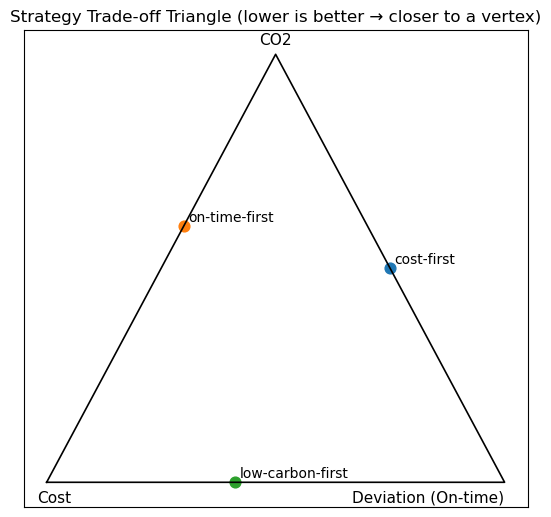

In [23]:
# --- Trade-off Triangle for 3 strategies ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

df = pd.read_csv("strategy_comparison.csv")

cols = ["Total_Cost", "Deviation_Hours", "CO2e_Proxy"]
assert set(cols).issubset(df.columns), "strategy_comparison.csv must contain Total_Cost, Deviation_Hours, CO2e_Proxy"

norm = {}
for c in cols:
    v = df[c].astype(float).values
    v_min, v_max = v.min(), v.max()

    if np.isclose(v_max, v_min):
        norm[c] = np.full_like(v, 0.5, dtype=float)
    else:
        norm[c] = (v - v_min) / (v_max - v_min)

cost_s = norm["Total_Cost"]
dev_s  = norm["Deviation_Hours"]
co2_s  = norm["CO2e_Proxy"]


total = cost_s + dev_s + co2_s
total = np.where(np.isclose(total, 0), 1.0, total)
A = cost_s / total    
B = dev_s  / total    
C = co2_s  / total    

X = B + 0.5*C
Y = (sqrt(3)/2.0) * C

fig, ax = plt.subplots(figsize=(6.5, 6.2))

tri_x = [0.0, 1.0, 0.5, 0.0]
tri_y = [0.0, 0.0, sqrt(3)/2.0, 0.0]
ax.plot(tri_x, tri_y, 'k-', lw=1.2)

for i, row in df.iterrows():
    ax.scatter(X[i], Y[i], s=60)
    ax.text(X[i]+0.01, Y[i]+0.01, row["Strategy"], fontsize=10)

ax.set_xlim(-0.05, 1.05); ax.set_ylim(-0.05, (sqrt(3)/2)+0.05)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title("Strategy Trade-off Triangle (lower is better → closer to a vertex)")

ax.text(-0.02, -0.04, "Cost", fontsize=11)
ax.text(1.00, -0.04, "Deviation (On-time)", fontsize=11, ha="right")
ax.text(0.50, (sqrt(3)/2)+0.02, "CO2", fontsize=11, ha="center")

plt.show()


In [24]:
# --- Build three policy maps and a side-by-side comparison page ---
import pandas as pd
import folium
from branca.colormap import LinearColormap
from pathlib import Path

PLANS = {
    "cost-first"      : "optimized_plan_cost-first.csv",
    "on-time-first"   : "optimized_plan_on-time-first.csv",
    "low-carbon-first": "optimized_plan_low-carbon-first.csv",
}
COORDS_FILE = "hub_coords.csv"   
COLOR_COL   = "unit_cost"       

def make_map(plan_csv, coords_csv, color_col="unit_cost", out_html=None):
    plan = pd.read_csv(plan_csv)
    coords = pd.read_csv(coords_csv) 
    nodes = coords.set_index("hub")[["lat","lon"]].to_dict("index")

    center = (coords["lat"].mean(), coords["lon"].mean())
    m = folium.Map(location=center, zoom_start=4, tiles="cartodbpositron")


    vmin, vmax = plan[color_col].min(), plan[color_col].max()
    cmap = LinearColormap(
        ["#2c7bb6","#abd9e9","#ffffbf","#fdae61","#d7191c"],
        vmin=float(vmin), vmax=float(vmax)
    )

    max_flow = max(float(plan["flow"].max()), 1.0)
    for _, r in plan.iterrows():
        u, v = int(r["hub_u"]), int(r["hub_v"])
        if u in nodes and v in nodes:
            latlngs = [(nodes[u]["lat"], nodes[u]["lon"]), (nodes[v]["lat"], nodes[v]["lon"])]
            w = max(1.0, 8.0 * (float(r["flow"]) / max_flow))  
            color = cmap(float(r[color_col]))
            folium.PolyLine(
                latlngs, color=color, weight=w, opacity=0.9,
                tooltip=f"{u}→{v} | flow={r['flow']:.1f} | {color_col}={float(r[color_col]):.2f}"
            ).add_to(m)

    for _, row in coords.iterrows():
        folium.CircleMarker(
            (row["lat"], row["lon"]), radius=3, color="#333", fill=True, fill_opacity=0.9,
            tooltip=f"hub {int(row['hub'])}"
        ).add_to(m)

    cmap.caption = color_col
    cmap.add_to(m)

    if out_html is None:
        out_html = plan_csv.replace(".csv", f"__{color_col}.html")
    m.save(out_html)
    return out_html

out_files = []
for name, csv in PLANS.items():
    if not Path(csv).exists():
        print(f"{csv} not found, skip")
        continue
    html_path = make_map(csv, COORDS_FILE, color_col=COLOR_COL, out_html=f"map_{name}.html")
    out_files.append((name, html_path))
    print(f" saved → {html_path}")

comp_html = "maps_compare.html"
with open(comp_html, "w", encoding="utf-8") as f:
    f.write("""
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>Policy Maps Compare</title>
<style>
  body { margin: 0; font-family: sans-serif; }
  .row { display: flex; gap: 8px; padding: 8px; }
  .col { flex: 1 1 33%; border: 1px solid #ddd; }
  .title { text-align:center; font-weight:600; padding: 6px 0; }
  iframe { width: 100%; height: 78vh; border: 0; }
</style>
</head>
<body>
<div class="row">
""")
    for name, html in out_files:
        f.write(f"""
  <div class="col">
    <div class="title">{name}</div>
    <iframe src="{html}"></iframe>
  </div>
""")
    f.write("""
</div>
</body>
</html>
""")

print("side-by-side page →", comp_html)


 saved → map_cost-first.html
 saved → map_on-time-first.html
 saved → map_low-carbon-first.html
side-by-side page → maps_compare.html
